In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the dataset

In [3]:
file_path = "D:\\IIT\\Subjects\(4601)Computational Inteligence\\CW\\Implementation\\DataSet\\UK_Cities.csv"
data = pd.read_csv(file_path)

### Extract city coordinates

In [4]:
city_names = data['City'].values
coordinates = data[['Latitude', 'Longitude']].values

### Haversine formula to calculate distances between two latitude/longitude points

In [5]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

### Calculate the distance matrix

In [6]:
num_cities = len(coordinates)
distance_matrix = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        if i != j:
            distance_matrix[i][j] = haversine(
                coordinates[i][0], coordinates[i][1], coordinates[j][0], coordinates[j][1]
            )

### Genetic Algorithm Parameters

In [7]:
population_size = 50
num_generations = 200
mutation_rate = 0.02

### Generate initial population (random permutations of cities)

In [8]:
def generate_population(size, num_cities):
    return [np.random.permutation(num_cities) for _ in range(size)]

### Fitness function: Inverse of total distance

In [9]:
def calculate_fitness(route):
    total_distance = sum(
        distance_matrix[route[i], route[i + 1]] for i in range(len(route) - 1)
    )
    total_distance += distance_matrix[route[-1], route[0]]  # Return to starting city
    return 1 / total_distance

### Selection: Roulette Wheel

In [10]:
def select_parents(population, fitnesses):
    probabilities = fitnesses / np.sum(fitnesses)
    parents_indices = np.random.choice(len(population), size=2, p=probabilities, replace=False)
    return population[parents_indices[0]], population[parents_indices[1]]

### Crossover: Order Crossover (OX)

In [11]:
def order_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(np.random.choice(size, 2, replace=False))
    child = -np.ones(size, dtype=int)
    child[start:end] = parent1[start:end]
    remaining = [city for city in parent2 if city not in child]
    idx = 0
    for i in range(size):
        if child[i] == -1:
            child[i] = remaining[idx]
            idx += 1
    return child

### Mutation: Swap Mutation

In [12]:
def swap_mutation(route, mutation_rate):
    for i in range(len(route)):
        if np.random.random() < mutation_rate:
            j = np.random.randint(len(route))
            route[i], route[j] = route[j], route[i]
    return route

### Main Genetic Algorithm

In [13]:
def genetic_algorithm(num_cities, distance_matrix):
    population = generate_population(population_size, num_cities)
    best_route = None
    best_distance = float('inf')
    fitness_history = []
    
    for generation in range(num_generations):
        # Evaluate fitness
        fitnesses = np.array([calculate_fitness(route) for route in population])
        
        # Track the best solution
        best_idx = np.argmax(fitnesses)
        best_route_gen = population[best_idx]
        best_distance_gen = 1 / fitnesses[best_idx]
        if best_distance_gen < best_distance:
            best_distance = best_distance_gen
            best_route = best_route_gen
        
        # Save fitness history
        fitness_history.append(best_distance)
        
        # Create the next generation
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, fitnesses)
            child1 = order_crossover(parent1, parent2)
            child2 = order_crossover(parent2, parent1)
            new_population.extend([swap_mutation(child1, mutation_rate), swap_mutation(child2, mutation_rate)])
        population = new_population
    
    return best_route, best_distance, fitness_history

### Visualize the Best Route

In [14]:
def plot_route(route, coordinates, city_names):
    plt.figure(figsize=(12, 8))
    for i in range(len(route)):
        city_a = coordinates[route[i]]
        city_b = coordinates[route[(i + 1) % len(route)]]
        plt.plot([city_a[1], city_b[1]], [city_a[0], city_b[0]], 'b-')
    for i, city in enumerate(route):
        plt.plot(coordinates[city][1], coordinates[city][0], 'ro')
        plt.text(coordinates[city][1], coordinates[city][0], city_names[city], fontsize=9)
    plt.title(f'Best Route (Total Distance: {best_distance:.2f} km)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

## Run the Genetic Algorithm

In [15]:
best_route, best_distance, fitness_history = genetic_algorithm(num_cities, distance_matrix)

### Visualize the Best Route

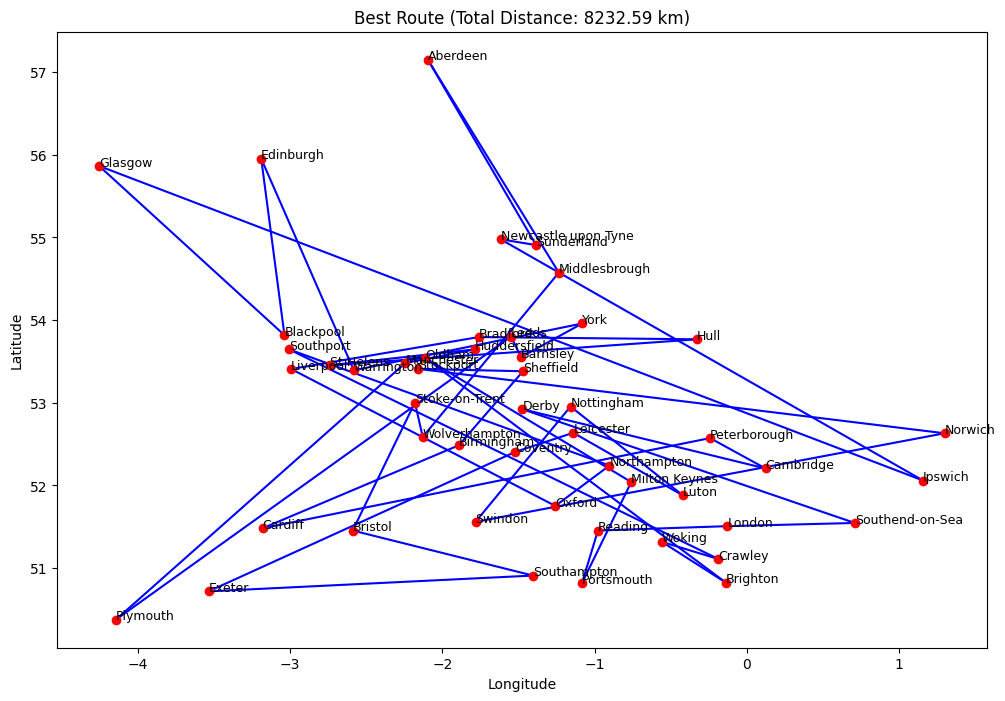

In [16]:
plot_route(best_route, coordinates, city_names)

### Plot Fitness History

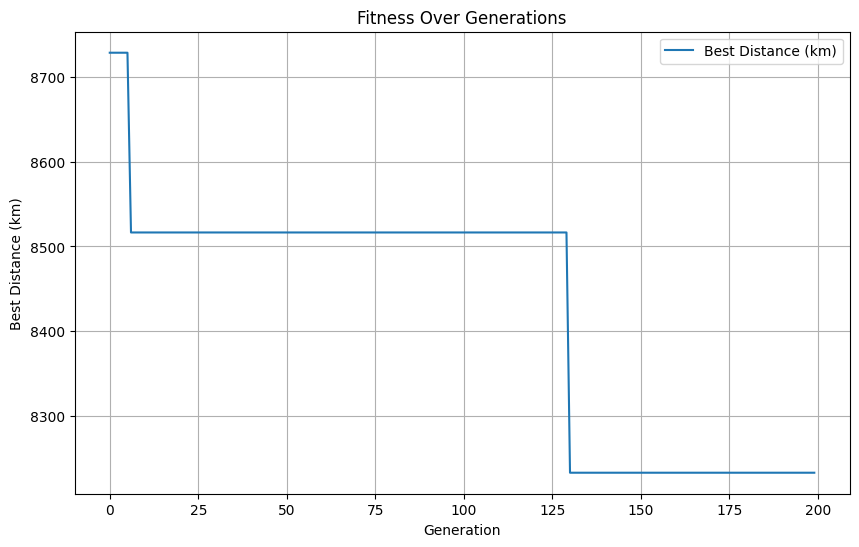

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(fitness_history)), fitness_history, label='Best Distance (km)')
plt.legend()
plt.grid()
plt.title('Fitness Over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Distance (km)')
plt.show()